In [299]:
from montecarlo import *
from portfolio import *
import math

# montecarlo e ef
PERIODS = 252
dur = 20
riskFreeRate = 0.01
num_portfolios = 5000

# randomwalk
NUM_YEARS = 10
NUM_MC_RUNS = 1000


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


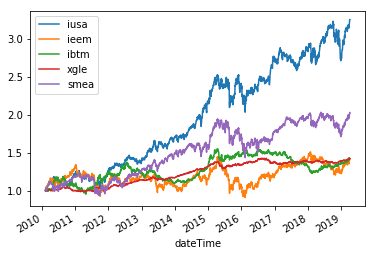

In [318]:
# data = pd.read_csv('quotes_clean_mach1.csv')  # daily quotes assets_all
#data = pd.read_csv('quote_mach2.csv')  # daily quotes assets_all
#data['dateTime'] = pd.to_datetime(data['dateTime'])
#data.set_index('dateTime', inplace=True)
assets_all = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau'] # **
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['iusa','imeu','ibtm','xgle','phau']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['xgle', 'ibtm', 'iusa', 'smea', 'ieem']

data = read_quotes(assets)

# correzione SMEA
if 'smea' in assets:
    x1 = data.smea.idxmin()
    data.smea.loc[x1] = data.smea.loc[x1 - pd.Timedelta(days=1)]

norm_data = data/data.iloc[0]
norm_data.plot()
# data.head()

## Montecarlo e Efficient Frontier

In [319]:
## MONTECARLO e Efficient Frontier
## portafoglio maxSharpe e minVar

results, meanDailyReturns, covMatrix = do_mc_simulation(data, assets, numPortfolios, PERIODS, riskFreeRate)

# Find efficient frontier
targetReturns = np.linspace(0.02, 0.12, 20)
efficientPortfolios = findEfficientFrontier(meanDailyReturns, 
                                            covMatrix, targetReturns, PERIODS)

# Find portfolio with maximum Sharpe ratio
maxSharpe = findMaxSharpeRatioPortfolio( meanDailyReturns, covMatrix,
                                        riskFreeRate, PERIODS)
retms, sdms = calcPortfolioPerf(maxSharpe['x'], meanDailyReturns, covMatrix, PERIODS)

# Find portfolio with minimum variance
minVar = findMinVariancePortfolio(meanDailyReturns, covMatrix, PERIODS)
retmv, sdmv = calcPortfolioPerf(minVar['x'], meanDailyReturns, covMatrix, PERIODS) 
    

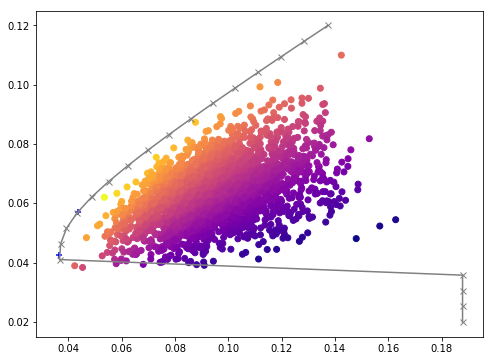

In [320]:
### PLOTTING

dfResults = pd.DataFrame(results.T)
dfResults.columns = ['ret','vola','sharpe']

fig10 = plt.figure(figsize = (8,6))
plt.scatter(dfResults.vola, dfResults.ret, c = dfResults.sharpe, marker = 'o', cmap='plasma')
plt.scatter(sdms, retms, c='blue', marker='+')
plt.scatter(sdmv, retmv, c='blue', marker='+')
plt.plot([p['fun'] for p in efficientPortfolios], targetReturns, marker='x', c='gray')

plt.show()



In [321]:
# maxSharpe _fra_ i portafogli generati random

dfResults.iloc[dfResults.sharpe.idxmax()]

ret       0.062049
vola      0.053562
sharpe    0.971755
Name: 2031, dtype: float64

## Random Walk

In [322]:
# da runnare solo una volta, altrimenti rovina norm_data
pndata = norm_data.copy()

weights = minVar['x']
pndata['minvar'] = norm_data.mul(weights,axis=1).sum(axis=1)

weights = maxSharpe['x']
pndata['maxSharpe'] = norm_data.mul(weights,axis=1).sum(axis=1)

# pndata.head()

In [324]:
pct_ret = pndata.pct_change()
pct_ret.dropna(inplace=True)
#pct_ret.head()

In [325]:
mc_runs, ann_mc_returns, vol_mc_returns, sharpe_mc_runs = do_mc_randomwalk(pct_ret, 
                                                                           NUM_MC_RUNS, NUM_YEARS, 
                                                                           riskFreeRate, PERIODS)

In [326]:
#plt.scatter(vol_mc_returns, ann_mc_returns, c = sharpe_mc_runs,marker = 'o')
#plt.colorbar(label = 'Sharpe Ratio')

In [327]:
mc_stats = pd.DataFrame()
for i in [0,500,1000,1500,2000,mc_runs.shape[0]-1]:
    mc_stats[i] = mc_runs.iloc[i,:].describe([.1,.25,.5,.75,.9])

In [328]:
# mc_stats

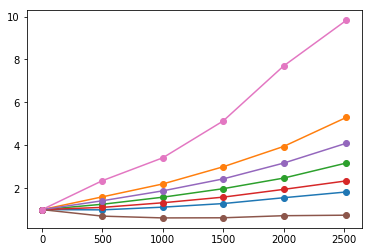

In [329]:
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['10%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['90%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['50%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['25%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['75%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['min'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['max'], marker='o')
plt.show()

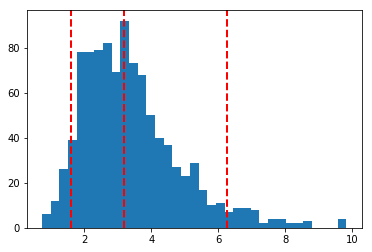

In [332]:
# Statistiche solo sul risultato finale

mc_end_results = mc_runs.iloc[2520]

plt.hist(mc_end_results, bins=35)
plt.axvline(mc_end_results.quantile(0.05), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.95), color='r', linestyle='dashed', linewidth=2)
plt.show()